In [1]:
import numpy as np

import torch
from torch.utils.data import DataLoader, TensorDataset

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

import matplotlib.pyplot as plt

In [2]:
import nir
from rockpool.nn.modules.torch.nir import from_nir, to_nir

nirgraph = nir.read('braille_subtract.nir')
net = from_nir(nirgraph)

Shape [55]
Shape [7]


In [4]:
net

GraphExecutor(
  (fc1): LinearTorch()
  (fc2): LinearTorch()
  (lif1_lif): LIFTorch()
  (lif1_w_rec): LinearTorch()
  (lif2): LIFTorch()
)

In [5]:
# Impose common `dt`
dt = 1e-3

net.lif1_lif.dt = dt
net.lif2.dt = dt

In [6]:
from rockpool.devices.xylo.syns61201 import mapper, config_from_specification, XyloSim, XyloSamna
from rockpool.transform.quantize_methods import channel_quantize

spec = mapper(net.as_graph())

/Users/dylan/SynSense Dropbox/Dylan Muir/LiveSync/Development/Projects/nir/rockpool_nir/rockpool/devices/xylo/syns61300/xylo_mapper.py:190: DRCWarning: Bias parameters of LinearWeights modules are *not* transferred to Xylo.
Found weights LinearWeights "LinearTorch__4390929888" with 12 input nodes -> 55 output nodes with biases. Set `has_bias = False` for this module .
  warnings.warn(
/Users/dylan/SynSense Dropbox/Dylan Muir/LiveSync/Development/Projects/nir/rockpool_nir/rockpool/devices/xylo/syns61300/xylo_mapper.py:190: DRCWarning: Bias parameters of LinearWeights modules are *not* transferred to Xylo.
Found weights LinearWeights "LinearTorch__5551354688" with 55 input nodes -> 55 output nodes with biases. Set `has_bias = False` for this module .
  warnings.warn(
/Users/dylan/SynSense Dropbox/Dylan Muir/LiveSync/Development/Projects/nir/rockpool_nir/rockpool/devices/xylo/syns61300/xylo_mapper.py:190: DRCWarning: Bias parameters of LinearWeights modules are *not* transferred to Xylo.


In [7]:
Qspec = spec
Qspec.update(channel_quantize(**Qspec))
Qspec.pop('mapped_graph')

config, is_valid, msg = config_from_specification(**spec)

if not is_valid:
    print(msg)

TypeError: <class 'numpy.int8'> could not be casted to expected type (unsigned char), integer bounds [0,255]

In [6]:
mod = XyloSim.from_config(config, dt = dt)
mod

XyloSim  with shape (16, 1000, 8)

In [8]:
### TEST DATA
test_data_path = "data/ds_test.pt"
ds_test = torch.load(test_data_path)
letter_written = ["Space", "A", "E", "I", "O", "U", "Y"]


[  0 243   2 252   0   0 251]
Predicted Label: 3
Actual Label:    4


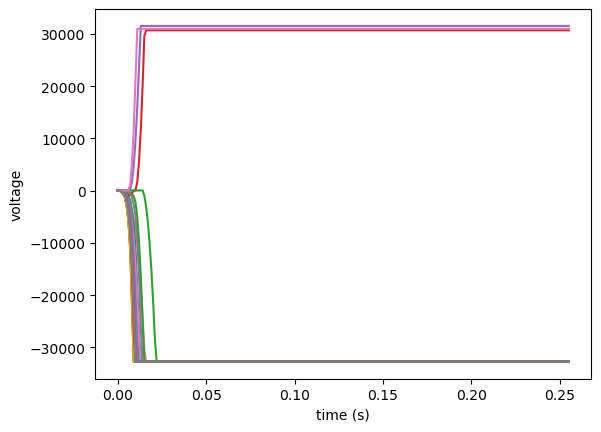

n_correct 0 out of 1


In [9]:

### RUN TESTS
n_samples = 1  # dataset size: 140
do_plot = True
predicted_labels = []
actual_labels = []

for i in range(n_samples):
    single_sample = next(iter(DataLoader(ds_test, batch_size=1, shuffle=True)))
    sample = single_sample[0].numpy()[0]  # shape: (256, 12)

    output, _, rec_dict = mod(sample, record = True)

    spike_times, spike_channels = np.nonzero(output)
    voltages = rec_dict['Vmem']

    # print(spike_times)
    # print(outp[0].params)

    n_output_spikes = np.sum(output, axis=0)

    print(n_output_spikes)
    predicted_label = int(np.argmax(n_output_spikes))
    actual_label = int(single_sample[1])
    print("Predicted Label:", predicted_label)
    print("Actual Label:   ", actual_label)
    predicted_labels.append(predicted_label)
    actual_labels.append(actual_label)

    if do_plot:
        times = np.arange(np.shape(output)[0]) * dt
        plt.plot(times, voltages)
        plt.xlabel("time (s)")
        plt.ylabel("voltage")
        plt.show()

predicted_labels = np.array(predicted_labels)
actual_labels = np.array(actual_labels)
n_correct = np.count_nonzero(predicted_labels == actual_labels)
print("n_correct", n_correct, "out of", n_samples)